# Pseudomonas experiment level analysis

Main notebook to run experiment-level simulation experiment using *P. aeruginosa* gene expression data.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import ast
import pandas as pd
import numpy as np
import random
from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='ignore')

from ponyo import pipeline, utils

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs", 
                                           "config_test_Pa_experiment_limma.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
correction_method = params["correction_method"]
lst_num_partitions = params["lst_num_partitions"]
train_architecture = params['NN_architecture']

In [4]:
# Input files
normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "train_set_normalized_test.tsv")

metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "sample_annotations.tsv")

In [5]:
# Output files
normalized_processed_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "train_set_normalized_processed_test.txt.xz")

## Setup directories

In [6]:
pipeline.setup_dir(config_file)

## Process data
This pipeline is expecting data to be of the form sample x gene. The downloaded data is gene x sample.

In [7]:
pipeline.transpose_data(normalized_data_file,
                       normalized_processed_data_file)

## Pre-process data

In [8]:
# Output file
experiment_id_file = os.path.join(
    base_dir, 
    dataset_name,
    "data",
    "metadata", 
    "experiment_ids.txt")

In [9]:
pipeline.create_experiment_id_file(metadata_file,
                                      normalized_processed_data_file,
                                      experiment_id_file,
                                      config_file)

There are 135 experiments in the compendium
There are 5 experiments with gene expression data
5 experiment ids saved to file


## Train VAE

In [10]:
# Directory containing log information from VAE training
vae_log_dir = os.path.join(
    base_dir, 
    dataset_name,
    "logs",
    train_architecture)

input dataset contains 11 samples and 5549 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.
Train on 10 samples, validate on 1 samples
Epoch 1/5
10/10 [==============================] - 1s 117ms/step - loss: 3858.4126 - val_loss: 3735.3594
Epoch 2/5
10/10 [==============================] - 1s 58ms/step - loss: 3718.5757 - val_loss: 3637.9312
Epoch 3/5
10/10 [==============================] - 1s 61ms/step - loss: 3609.0437 - val_loss: 3538.1511
Epoch 4/5
10/10 [==============================] - 1s 54ms/step - loss: 3523.7488 - val_loss: 3493.7456
Epoch 5/5
10/10 [==============================] - 1s 53ms/step - loss: 3459.9624 - val_loss: 3830.6794


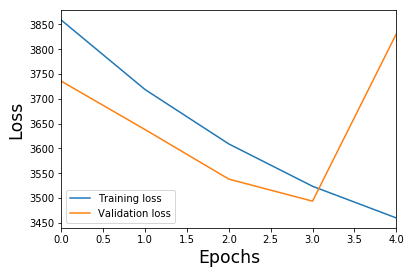

In [11]:
# Train VAE
pipeline.train_vae(config_file,
                   normalized_processed_data_file)

## Run simulation experiment without noise correction

In [12]:
# Run simulation without correction 
corrected=False
pipeline.run_simulation(config_file,
                        normalized_processed_data_file,
                        corrected,
                        experiment_id_file)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   36.8s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   38.1s remaining:   57.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   38.6s remaining:   25.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   41.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   41.4s finished
                         score
number of partitions          
1                     0.999980
5                     0.764472
50                    0.833831
                             score
number of partitions              
1                     9.271507e-07
5                     5.834413e-03
50                    1.065429e-02
                          ymin      ymax
number of partitions                    
1                     0.999979  0.999982
5                     0.753037  0.775908
50                    0.812949  0.854714


## Run simulation with correction applied

In [13]:
# Run simulation without correction
corrected=True
pipeline.run_simulation(config_file,
                        normalized_processed_data_file,
                        corrected,
                        experiment_id_file)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   21.6s remaining:   14.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   24.8s finished
                         score
number of partitions          
1                     0.999980
5                     0.917368
50                    0.237713
                             score
number of partitions              
1                     9.356547e-07
5                     4.332237e-03
50                    6.157764e-03
                          ymin      ymax
number of partitions                    
1                     0.999978  0.999982
5                     0.908877  0.925860
50                    0.225644  0.249782


## Make figures

In [14]:
pca_ind = [0,1,2]

In [15]:
# File directories
similarity_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_svcca_uncorrected_" + correction_method + ".pickle")

ci_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_ci_uncorrected_" + correction_method + ".pickle")

similarity_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_svcca_corrected_" + correction_method + ".pickle")

ci_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_ci_corrected_" + correction_method + ".pickle")

permuted_score_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_permuted.npy")

compendia_dir = os.path.join(
    local_dir,
    "partition_simulated",
    dataset_name + "_" + analysis_name)

In [16]:
# Output files
svcca_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_svcca_"+correction_method+".svg")

svcca_png_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_svcca_"+correction_method+".png")

pca_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_pca_uncorrected_"+correction_method+".svg")

pca_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_pca_corrected_"+correction_method+".svg")

In [17]:
# Load pickled files
uncorrected_svcca = pd.read_pickle(similarity_uncorrected_file)
err_uncorrected_svcca = pd.read_pickle(ci_uncorrected_file)
corrected_svcca = pd.read_pickle(similarity_corrected_file)
err_corrected_svcca = pd.read_pickle(ci_corrected_file)

permuted_score = np.load(permuted_score_file)

In [18]:
# Concatenate error bars
uncorrected_svcca_err = pd.concat([uncorrected_svcca, err_uncorrected_svcca], axis=1)
corrected_svcca_err = pd.concat([corrected_svcca, err_corrected_svcca], axis=1)

In [19]:
# Add group label
uncorrected_svcca_err['Group'] = 'uncorrected'
corrected_svcca_err['Group'] = 'corrected'

In [20]:
# Concatenate dataframes
all_svcca = pd.concat([uncorrected_svcca_err, corrected_svcca_err])
all_svcca

,score,ymin,ymax,Group
number of partitions,,,,
1,0.999980,0.999979,0.999982,uncorrected
5,0.764472,0.753037,0.775908,uncorrected
50,0.833831,0.812949,0.854714,uncorrected
1,0.999980,0.999978,0.999982,corrected
5,0.917368,0.908877,0.925860,corrected
50,0.237713,0.225644,0.249782,corrected


### SVCCA 

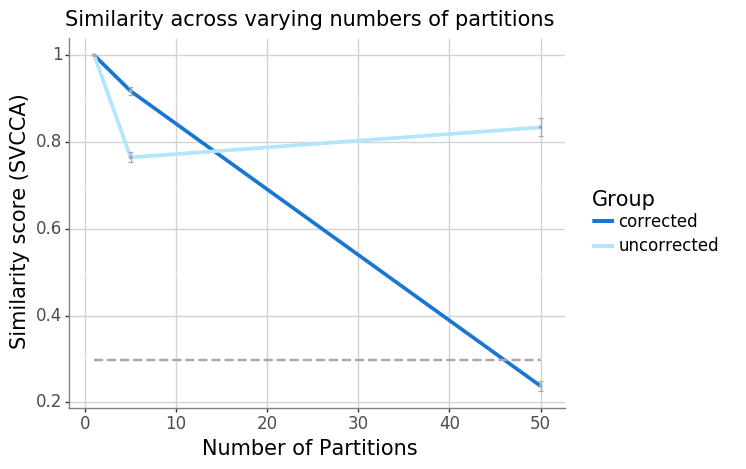

<ggplot: (-9223363276744375229)>


In [21]:
# Plot
lst_num_partitions = list(all_svcca.index)

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

panel_A = ggplot(all_svcca) \
    + geom_line(all_svcca,
                aes(x=lst_num_partitions, y='score', color='Group'),
                size=1.5) \
    + geom_point(aes(x=lst_num_partitions, y='score'), 
                 color ='darkgrey',
                size=0.5) \
    + geom_errorbar(all_svcca,
                  aes(x=lst_num_partitions, ymin='ymin', ymax='ymax'),
                   color='darkgrey') \
    + geom_line(threshold, 
                aes(x=lst_num_partitions, y='score'), 
                linetype='dashed',
                size=1,
                color="darkgrey",
                show_legend=False) \
    + labs(x = "Number of Partitions", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity across varying numbers of partitions") \
    + theme(
            plot_background=element_rect(fill="white"),
            panel_background=element_rect(fill="white"),
            panel_grid_major_x=element_line(color="lightgrey"),
            panel_grid_major_y=element_line(color="lightgrey"),
            axis_line=element_line(color="grey"),
            legend_key=element_rect(fill='white', colour='white'),
            legend_title=element_text(family='sans-serif', size=15),
            legend_text=element_text(family='sans-serif', size=12),
            plot_title=element_text(family='sans-serif', size=15),
            axis_text=element_text(family='sans-serif', size=12),
            axis_title=element_text(family='sans-serif', size=15)
           ) \
    + scale_color_manual(['#1976d2', '#b3e5fc']) \


print(panel_A)
ggsave(plot=panel_A, filename=svcca_file, device="svg", dpi=300)
ggsave(plot=panel_A, filename=svcca_png_file, device="svg", dpi=300)

### Uncorrected PCA

In [22]:
lst_num_partitions = [lst_num_partitions[i] for i in pca_ind]

all_data_df = pd.DataFrame()

# Get batch 1 data
partition_1_file = os.path.join(
    compendia_dir,
    "Partition_1_0.txt.xz")

partition_1 = pd.read_table(
    partition_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_partitions:
    print('Plotting PCA of 1 parition vs {} partition...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  partition_1.copy()
    
    # Add grouping column for plotting
    original_data_df['num_partitions'] = '1'
    
    # Get data with additional batch effects added
    partition_other_file = os.path.join(
        compendia_dir,
        "Partition_"+str(i)+"_0.txt.xz")

    partition_other = pd.read_table(
        partition_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    partition_data_df =  partition_other
    
    # Add grouping column for plotting
    partition_data_df['num_partitions'] = 'multiple'
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, partition_data_df])

    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['num_partitions'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
                                              
    # Variance explained
    print(pca.explained_variance_ratio_)  
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_partitions'] = combined_data_df['num_partitions']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])     

Plotting PCA of 1 parition vs 1 partition...
[0.55408816 0.08039057]
Plotting PCA of 1 parition vs 5 partition...
[0.40020729 0.08856502]
Plotting PCA of 1 parition vs 50 partition...
[0.39292195 0.0605442 ]


In [23]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_partitions_str = [str(i) for i in lst_num_partitions]
num_partitions_cat = pd.Categorical(all_data_df['num_partitions'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_data_df['comparison'], categories=lst_num_partitions_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_partitions_cat = num_partitions_cat)
all_data_df = all_data_df.assign(comparison_cat = comparison_cat)

In [24]:
all_data_df.columns = ['PC1', 'PC2', 'num_partitions', 'comparison', 'No. of partitions', 'Comparison']

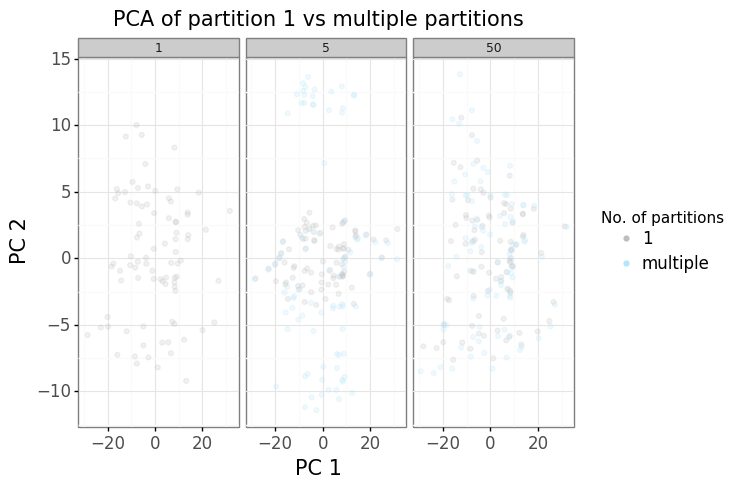

<ggplot: (8760095626020)>


In [25]:
# Plot all comparisons in one figure
panel_B = ggplot(all_data_df[all_data_df['Comparison'] != '1'],
                 aes(x='PC1', y='PC2')) \
    + geom_point(aes(color='No. of partitions'), 
                 alpha=0.2) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1", 
           y = "PC 2", 
           title = "PCA of partition 1 vs multiple partitions") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        legend_text=element_text(family='sans-serif', size=12),
        plot_title=element_text(family='sans-serif', size=15),
        axis_text=element_text(family='sans-serif', size=12),
        axis_title=element_text(family='sans-serif', size=15)
    ) \
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#b3e5fc']) \
    + geom_point(data=all_data_df[all_data_df['Comparison'] == '1'],
                 alpha=0.1, 
                 color='#bdbdbd')

print(panel_B)
ggsave(plot=panel_B, filename=pca_uncorrected_file)

### Corrected PCA

In [26]:
lst_num_partitions = [lst_num_partitions[i] for i in pca_ind]

all_corrected_data_df = pd.DataFrame()

# Get batch 1 data
partition_1_file = os.path.join(
    compendia_dir,
    "Partition_corrected_1_0.txt.xz")

partition_1 = pd.read_table(
    partition_1_file,
    header=0,
    index_col=0,
    sep='\t')

# Transpose data to df: sample x gene
partition_1 = partition_1.T

for i in lst_num_partitions:
    print('Plotting PCA of 1 partition vs {} partitions...'.format(i))
    
     # Simulated data with all samples in a single batch
    original_data_df =  partition_1.copy()
    
    # Match format of column names in before and after df
    original_data_df.columns = original_data_df.columns.astype(str)
    
    # Add grouping column for plotting
    original_data_df['num_partitions'] = '1'
    
    # Get data with additional batch effects added and corrected
    partition_other_file = os.path.join(
        compendia_dir,
        "Partition_corrected_"+str(i)+"_0.txt.xz")

    partition_other = pd.read_table(
        partition_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Transpose data to df: sample x gene
    partition_other = partition_other.T
    
    # Simulated data with i batch effects that are corrected
    partition_data_df =  partition_other
    
    # Add grouping column for plotting
    partition_data_df['num_partitions'] = 'multiple'
    
    # Match format of column names in before and after df
    partition_data_df.columns = original_data_df.columns.astype(str)
        
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, partition_data_df])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space    
    combined_data_numeric_df = combined_data_df.drop(['num_partitions'], axis=1)    
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)

    
    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_partitions'] = combined_data_df['num_partitions']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_corrected_data_df = pd.concat([all_corrected_data_df, combined_data_PCAencoded_df])

Plotting PCA of 1 partition vs 1 partitions...
Plotting PCA of 1 partition vs 5 partitions...
Plotting PCA of 1 partition vs 50 partitions...


In [27]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_partitions_str = [str(i) for i in lst_num_partitions]
num_partitions_cat = pd.Categorical(all_corrected_data_df['num_partitions'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_corrected_data_df['comparison'], categories=lst_num_partitions_str)

# Assign to a new column in the df
all_corrected_data_df = all_corrected_data_df.assign(num_partitions_cat = num_partitions_cat)
all_corrected_data_df = all_corrected_data_df.assign(comparison_cat = comparison_cat)

In [28]:
all_corrected_data_df.columns = ['PC1', 'PC2', 'num_partitions', 'comparison', 'No. of partitions', 'Comparison']

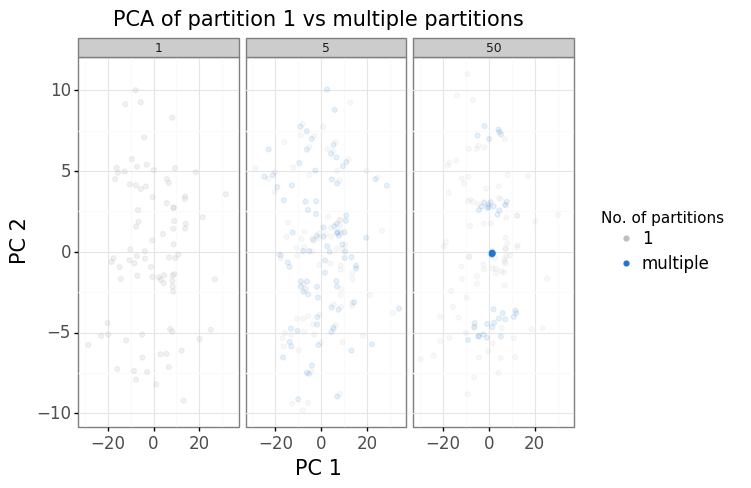

<ggplot: (-9223363276759350100)>


In [29]:
# Plot all comparisons in one figure
panel_C = ggplot(all_corrected_data_df[all_corrected_data_df['Comparison'] != '1'],
                 aes(x='PC1', 
                     y='PC2')) \
    + geom_point(aes(color='No. of partitions'), 
                 alpha=0.1) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1", 
           y = "PC 2", 
           title = "PCA of partition 1 vs multiple partitions") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        legend_text=element_text(family='sans-serif', size=12),
        plot_title=element_text(family='sans-serif', size=15),
        axis_text=element_text(family='sans-serif', size=12),
        axis_title=element_text(family='sans-serif', size=15)
    ) \
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#1976d2']) \
    + geom_point(data=all_corrected_data_df[all_corrected_data_df['Comparison'] == '1'],
                 alpha=0.1, 
                 color='#bdbdbd')

print(panel_C)
ggsave(plot=panel_C, filename=pca_corrected_file)